# Carga de Librerias

In [ ]:
# gestión de datos
import numpy as np
import pandas as pd
import math
import pickle
import os

# gráficos
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from scipy.cluster.hierarchy import linkage, dendrogram

# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans


# modelos
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier # Stochastic Gradient Descent Classifier: el equivalente del Adaline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression # Predeccion de probabilidad lineal

# guardar modelo pipline
import joblib

# pipelines
from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.compose import ColumnTransformer

# metricas
import sklearn.metrics as metrics

# hiperparametrizado
from sklearn.model_selection import GridSearchCV

# interpretabilidad
import shap

# para visualizar mas columnas en un df
pd.set_option('display.max_columns',None)

import warnings
warnings.filterwarnings("ignore")  # inhabilita warnings
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

np.random.seed(42)

## Carga de Dataset

In [3]:
CWD = os.getcwd()
DATA_PATH = os.path.join(CWD)

print(CWD)
print(DATA_PATH)
print(os.listdir(DATA_PATH))

c:\Users\gaspi\Desktop\TFM--DSMarket
c:\Users\gaspi\Desktop\TFM--DSMarket
['.git', '.gitignore', '1.DsMarket_Limpieza_datos.ipynb', '2.DsMarket_Clustering_productos.ipynb', '3.DsMarket_Forecast_by_cluster.ipynb', 'daily_calendar_with_events.csv', 'df_sales_wprice.csv', 'df_sales_wprice.pkl', 'df_wcluster_all_k7.pkl', 'df_wprediction.pkl', 'DsMarket.pbix', 'Forecast old', 'item_prices.csv', 'item_sales.csv', 'test_results.pkl']


In [4]:
df_original = pd.read_pickle(DATA_PATH + "/df_sales_wprice.pkl")

In [ ]:
df = df_original.copy()

## Carga de colores

In [6]:
info_naranja = "#F4B13E" # Naranja
info_azuloscuro = "#002333" # Azul Oscuro
info_verde = "#159A9C" # Verde
titulos_graficos = "#B4BEC9" # Gris

- Al ya haber realizado el EDA y preprocesado de datos no analizaremos los datos profundamente

# EDA

In [7]:
def report_df(df, verbose = True):
    '''
    Hace un report simple sobre el DataFrame suministrado.
    '''
    print(df.info(verbose = verbose))
    total_nulos = df.isnull().sum().sum()
    print()
    print(f"Tenemos un total de {total_nulos} nulos")

In [8]:
report_df(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58327370 entries, 0 to 58327369
Data columns (total 12 columns):
 #   Column       Dtype         
---  ------       -----         
 0   item         object        
 1   category     object        
 2   department   object        
 3   store        object        
 4   city         object        
 5   Qsale        int64         
 6   date         datetime64[ns]
 7   yearweek     object        
 8   event        object        
 9   weekday      int64         
 10  unit_price   float64       
 11  total_venta  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(7)
memory usage: 5.2+ GB
None

Tenemos un total de 0 nulos


Chequeamos cantidad de item unicos que hay

In [9]:
df['item'].nunique()

3049

Se eliminan las columnas store y city ya que analizaremos los items sin importar las tiendas donde se venden

In [10]:
df.drop(columns=["store","city","total_venta",'weekday'],inplace=True)

In [11]:
df.dtypes

item                  object
category              object
department            object
Qsale                  int64
date          datetime64[ns]
yearweek              object
event                 object
unit_price           float64
dtype: object

Vemos si hay dias en los que no haya ventas

In [12]:
df_by_date = df.groupby('date')['Qsale'].sum()

In [13]:
df_by_date[df_by_date==0]

Series([], Name: Qsale, dtype: int64)

Se observa que hay ventas todos los dias, por lo que nunca estan todas las tiendas cerradas en simultaneo

In [14]:
df['Qsale'].sum()

65695409

In [15]:
# agrupo las ventas de cada item
df['Qsale'] = df.groupby(['item','date'])['Qsale'].transform(np.sum)
# calculo el precio de cada item como el promedio entre los precios de cada tienda
df['unit_price'] = df.groupby(['item','date'])['unit_price'].transform(np.mean)

In [16]:
df = df.sort_values(['item','date'])

In [17]:
df.reset_index(drop=True,inplace=True)

In [18]:
df = df.drop_duplicates()

In [19]:
# Check de que no cambio el total de ventas
df['Qsale'].sum()

65695409

Crear columnas de año, mes, dia y dia de la semana

In [20]:
# Desglosar la columna 'date' en 'year', 'quarter', 'month', 'day' y 'weekday'
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['week'] = df['date'].dt.isocalendar().week
df['weekday'] = df['date'].dt.dayofweek
df['quarter'] = df['date'].dt.quarter

In [21]:
#se pasa la Columna event a Flag
df['event'] = df['event'].map(lambda x: 0 if x == 'No_event' else 1)

In [22]:
df.head()

,item,category,department,Qsale,date,yearweek,event,unit_price,year,month,day,week,weekday,quarter
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,0,2011-01-29,201105,0,11.95936,2011,1,29,4,5,1
10,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,0,2011-01-30,201105,0,11.95936,2011,1,30,4,6,1
20,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,0,2011-01-31,201105,0,11.95936,2011,1,31,5,0,1
30,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,0,2011-02-01,201105,0,11.95936,2011,2,1,5,1,1
40,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,0,2011-02-02,201105,0,11.95936,2011,2,2,5,2,1


# Features a implementar

### Monetary value


total_revenue

average_daily_revenue

average_weekly_revenue

average_monthly_revenue

max_daily_revenue

max_weekly_revenue

max_monthly_revenue

average_price

std_average_price (desviación estandar del precio medio, para caracterizar productos de temporada).

max_price_change (porcentaje de cambio de precio respeto la semana anterior)

min_price_change

flag_high_price (si el precio del producto es más alto que la media de su departamento)

flag_high_sells (si la total_units_sold del producto es más alto que la media de su departamento)

flag_high_revenue (si el total_revenue del producto es más alto que la media de su departamento)

total_units_sold


#### Revenue

In [23]:
#Revenue por linea
df['total_revenue'] = df['Qsale'] * df['unit_price']

In [24]:
#Revenue por dia / Promedio
daily_revenue = df.groupby(['item', 'date'])['total_revenue'].sum().reset_index()
df = df.merge(daily_revenue.groupby('item')['total_revenue'].mean().reset_index().rename(columns={'total_revenue': 'average_daily_revenue'}), on='item')

In [25]:
#Revenue por semana / Promedio
weekly_revenue = df.groupby(['item', 'yearweek'])['total_revenue'].sum().reset_index()
df = df.merge(weekly_revenue.groupby('item')['total_revenue'].mean().reset_index().rename(columns={'total_revenue': 'average_weekly_revenue'}), on='item')

In [26]:
#Revenue por mes / Promedio
monthly_revenue = df.groupby(['item', df['date'].dt.to_period('M')])['total_revenue'].sum().reset_index()
df = df.merge(monthly_revenue.groupby('item')['total_revenue'].mean().reset_index().rename(columns={'total_revenue': 'average_monthly_revenue'}), on='item')

In [27]:
#Revenue por Q / Promedio
quarterly_revenue = df.groupby(['item', df['date'].dt.to_period('Q')])['total_revenue'].sum().reset_index()
df = df.merge(quarterly_revenue.groupby('item')['total_revenue'].mean().reset_index().rename(columns={'total_revenue': 'average_quarterluy_revenue'}), on='item')

Agregamos columnas con los revenues maximos por dia, semana y mes

In [28]:
df = df.merge(daily_revenue.groupby('item')['total_revenue'].max().reset_index().rename(columns={'total_revenue': 'max_daily_revenue'}), on='item')

In [29]:
df = df.merge(weekly_revenue.groupby('item')['total_revenue'].max().reset_index().rename(columns={'total_revenue': 'max_weekly_revenue'}), on='item')

In [30]:
df = df.merge(monthly_revenue.groupby('item')['total_revenue'].max().reset_index().rename(columns={'total_revenue': 'max_monthly_revenue'}), on='item')

In [31]:
df = df.merge(quarterly_revenue.groupby('item')['total_revenue'].max().reset_index().rename(columns={'total_revenue': 'max_quarterly_revenue'}), on='item')

In [32]:
# Calcular el promedio de precio por item
item_avg_price = df.groupby('item')['unit_price'].transform('mean')

# Calcular el promedio de precio por department
department_avg_price = df.groupby('department')['unit_price'].transform('mean')

# Crear el flag de precio alto comparando el promedio del item con el promedio del department
df['flag_high_price'] = item_avg_price > department_avg_price

In [33]:
# Calcular el promedio de ventas total por item
item_avg_sells = df.groupby('item')['Qsale'].transform('mean')

# Calcular el promedio de ventas por department
department_avg_sells = df.groupby('department')['Qsale'].transform('mean')

# Crear el flag para cada item comparando su promedio de ventas con el promedio de ventas del department
df['flag_high_sells'] = item_avg_sells > department_avg_sells

In [34]:
# Calcular el promedio de revenue total por item
item_avg_revenue = df.groupby('item')['total_revenue'].transform('mean')

# Calcular el promedio de revenue total por department
department_avg_revenue = df.groupby('department')['total_revenue'].transform('mean')

# Crear el flag de revenue alto comparando el promedio del item con el promedio del department
df['flag_high_revenue'] = item_avg_revenue > department_avg_revenue


Se crea una formula para ver si el item es top o no dentro de us mismo departamento, segun precio, ventas o revenue
Flata aplicar la formula

In [35]:
def get_is_top_price_in_department(row):
  if row['average_price_per_unit'] > row['department_average_price_per_unit']:
    row['is_top_price_in_department'] = True
  else:
    row['is_top_price_in_department'] = False

  return row

def get_is_top_seller_in_department(row):
  if row['total_units_sold'] > row['department_average_units_sold']:
    row['is_top_seller_in_department'] = True
  else:
    row['is_top_seller_in_department'] = False

  return row


def get_is_high_revenue_in_department(row):
  if row['total_revenue'] > row['department_average_revenue']:
    row['is_high_revenue_in_department'] = True
  else:
    row['is_high_revenue_in_department'] = False

  return row

#### Price

In [36]:
#Precio promedio por item
df['average_price'] = df.groupby('item')['unit_price'].transform('mean')

In [37]:
#Cambio de precios y Precio maximo
df['price_change'] = df.groupby('item')['unit_price'].pct_change()
df['max_price_change'] = df.groupby('item')['price_change'].transform('max')

In [38]:
# Precio minimo
df['min_price_change'] = df.groupby('item')['price_change'].transform('min')

In [39]:
# cantidad de veces que cambio el precio
df['price_changes_total'] = df.groupby('item')['price_change'].transform('count')

### Frequency and intensity



average_daily_units_sold

average_weekly_units_sold

average_monthly_units_sold

average_trimestral_units_sold

max_daily_units_sold

min_daily_units_sold

max_weekly_units_sold

min_weekly_units_sold

max_monthly_units_sold

min_monthly_units_sold

max_days_from_last_sale

min_days_from_last_sale

days_from_last_sale_mean

flag_sells_every_month (True si el producto se vende cada mes)

Placement (el producto se vende todo el año o solo en determinadas fechas/temporadas? Se vende todo el año pero sus ventas

suben mucho cerca de un evento? Cual es el dia de la semana en el que se vende más? Dias del mes en que se vende más? Mes

del año en el que se vende más?)

flag_weekend (las ventas durate al menos un dia del fin de semana superan la media de la semana)

flag_half_week (las ventas durate al menos un dia entre miercoles y jueves superan la media de la semana)

flag_week_start (las ventas durate al menos un dia entre lunes y martes superan la media de la semana).

flag_month_start (las ventas durate al menos un dia entre los primeros 5 del mes superan la media mensual).

flag_half_month (las ventas durate al menos un dia entre los 5 dias centrales del mes, superan la media mensual).

flag_month_end (las ventas durate al menos un dia entre los ultimos 5 del mes, superan la media mensual).

flag_1st_trimester (las ventas durate el primer trimestre superan la media trimestral).

flag_2nd_trimester (las ventas durate el segundo trimestre superan la media trimestral).

flag_3rd_trimester (las ventas durate el tercer trimestre superan la media trimestral).

flag_4th_trimester (las ventas durate el cuarto trimestre superan la media trimestral).

Eventos: defino una feature por cada evento que indica si el item se vende màs cerca de ese evento, respeto al resto del

año. Ejemplo: is_NewYear_product es True si las ventas en la semana de New Year superan el promedio de las 2 semanas

anteriores.

In [40]:
#Total unidades vendidas
df['total_units_sold'] = df.groupby('item')['Qsale'].transform('sum')

In [41]:
# average_daily_units_sold
daily_units_sold = df.groupby(['item', 'date'])['Qsale'].sum().reset_index()
df = df.merge(daily_units_sold.groupby('item')['Qsale'].mean().reset_index().rename(columns={'Qsale': 'average_daily_units_sold'}), on='item')


In [42]:
# average_weekly_units_sold
weekly_units_sold = df.groupby(['item', 'yearweek'])['Qsale'].sum().reset_index()
df = df.merge(weekly_units_sold.groupby('item')['Qsale'].mean().reset_index().rename(columns={'Qsale': 'average_weekly_units_sold'}), on='item')

In [43]:
# average_monthly_units_sold
monthly_units_sold = df.groupby(['item', df['date'].dt.to_period('M')])['Qsale'].sum().reset_index()
df = df.merge(monthly_units_sold.groupby('item')['Qsale'].mean().reset_index().rename(columns={'Qsale': 'average_monthly_units_sold'}), on='item')

In [44]:
# average_monthly_units_sold
quarterly_units_sold = df.groupby(['item', df['date'].dt.to_period('Q')])['Qsale'].sum().reset_index()
df = df.merge(quarterly_units_sold.groupby('item')['Qsale'].mean().reset_index().rename(columns={'Qsale': 'average_quarterly_units_sold'}), on='item')

In [45]:

# max_daily_units_sold
df = df.merge(daily_units_sold.groupby('item')['Qsale'].max().reset_index().rename(columns={'Qsale': 'max_daily_units_sold'}), on='item')

In [46]:
# min_daily_units_sold
df = df.merge(daily_units_sold.groupby('item')['Qsale'].min().reset_index().rename(columns={'Qsale': 'min_daily_units_sold'}), on='item')

In [47]:
# max_weekly_units_sold
df = df.merge(weekly_units_sold.groupby('item')['Qsale'].max().reset_index().rename(columns={'Qsale': 'max_weekly_units_sold'}), on='item')

In [48]:
# min_weekly_units_sold
df = df.merge(weekly_units_sold.groupby('item')['Qsale'].min().reset_index().rename(columns={'Qsale': 'min_weekly_units_sold'}), on='item')

In [49]:
# max_monthly_units_sold
df = df.merge(monthly_units_sold.groupby('item')['Qsale'].max().reset_index().rename(columns={'Qsale': 'max_monthly_units_sold'}), on='item')

In [50]:
# min_monthly_units_sold
df = df.merge(monthly_units_sold.groupby('item')['Qsale'].min().reset_index().rename(columns={'Qsale': 'min_monthly_units_sold'}), on='item')

In [51]:
# max_quarterly_units_sold
df = df.merge(quarterly_units_sold.groupby('item')['Qsale'].max().reset_index().rename(columns={'Qsale': 'max_quarterly_units_sold'}), on='item')

In [52]:
# min_quarterly_units_sold
df = df.merge(quarterly_units_sold.groupby('item')['Qsale'].min().reset_index().rename(columns={'Qsale': 'min_quarterly_units_sold'}), on='item')

In [53]:
# df = df.sort_values(['item', 'date'])

# df['days_from_last_sale'] = (
#     df.groupby('item')['date']
#       .diff().dt.days
#       .fillna(0).astype(int)
# )
# 1) Fecha de “hoy” (sin hora)

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['item', 'date'])

# 2) Marca las fechas de venta (Qsale>0); las demás quedan NaT
df['last_sale_marker'] = df['date'].where(df['Qsale'] > 0)

# 3) Haz un ffill dentro de cada producto: cada fila hereda la última fecha de venta vista hasta ese punto
df['last_sale_cum'] = df.groupby('item')['last_sale_marker'].ffill()

# 4) Desplaza (“shift”) ese acumulado un paso atrás para que en cada fila quede la venta **anterior**, no la misma
df['prev_sale_date'] = df.groupby('item')['last_sale_cum'].shift()

# 5) Resta fechas para obtener días
df['days_from_last_sale'] = (df['date'] - df['prev_sale_date']).dt.days

# 6) (Opcional) limpia columnas intermedias
df = df.drop(columns=['last_sale_marker', 'last_sale_cum', 'prev_sale_date'])

# Listo: por ejemplo, las primeras filas de cada producto tendrán NaN
# porque no había “venta anterior” antes de la primera.

df["max_days_from_last_sale"] = df.groupby('item')['days_from_last_sale'].transform('max')
df["min_days_from_last_sale"] = df.groupby('item')['days_from_last_sale'].transform('min')
df["days_from_last_sale_mean"] = df.groupby('item')['days_from_last_sale'].transform('mean')
df

,item,category,department,Qsale,date,yearweek,event,unit_price,year,month,day,week,weekday,quarter,total_revenue,average_daily_revenue,average_weekly_revenue,average_monthly_revenue,average_quarterluy_revenue,max_daily_revenue,max_weekly_revenue,max_monthly_revenue,max_quarterly_revenue,flag_high_price,flag_high_sells,flag_high_revenue,average_price,price_change,max_price_change,min_price_change,price_changes_total,total_units_sold,average_daily_units_sold,average_weekly_units_sold,average_monthly_units_sold,average_quarterly_units_sold,max_daily_units_sold,min_daily_units_sold,max_weekly_units_sold,min_weekly_units_sold,max_monthly_units_sold,min_monthly_units_sold,max_quarterly_units_sold,min_quarterly_units_sold,days_from_last_sale,max_days_from_last_sale,min_days_from_last_sale,days_from_last_sale_mean
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,0,2011-01-29,201105,0,11.95936,2011,1,29,4,5,1,0.0,23.583257,164.652447,704.918288,2050.671382,165.0264,561.08976,2035.3256,5478.87648,True,False,False,11.468528,NaN,0.041027,-0.03941,1912,4093,2.139571,14.937956,63.953125,186.045455,15,0,51,0,185,0,498,0,NaN,3.0,1.0,1.044423
1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,0,2011-01-30,201105,0,11.95936,2011,1,30,4,6,1,0.0,23.583257,164.652447,704.918288,2050.671382,165.0264,561.08976,2035.3256,5478.87648,True,False,False,11.468528,0.0,0.041027,-0.03941,1912,4093,2.139571,14.937956,63.953125,186.045455,15,0,51,0,185,0,498,0,NaN,3.0,1.0,1.044423
2,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,0,2011-01-31,201105,0,11.95936,2011,1,31,5,0,1,0.0,23.583257,164.652447,704.918288,2050.671382,165.0264,561.08976,2035.3256,5478.87648,True,False,False,11.468528,0.0,0.041027,-0.03941,1912,4093,2.139571,14.937956,63.953125,186.045455,15,0,51,0,185,0,498,0,NaN,3.0,1.0,1.044423
3,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,0,2011-02-01,201105,0,11.95936,2011,2,1,5,1,1,0.0,23.583257,164.652447,704.918288,2050.671382,165.0264,561.08976,2035.3256,5478.87648,True,False,False,11.468528,0.0,0.041027,-0.03941,1912,4093,2.139571,14.937956,63.953125,186.045455,15,0,51,0,185,0,498,0,NaN,3.0,1.0,1.044423
4,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,0,2011-02-02,201105,0,11.95936,2011,2,2,5,2,1,0.0,23.583257,164.652447,704.918288,2050.671382,165.0264,561.08976,2035.3256,5478.87648,True,False,False,11.468528,0.0,0.041027,-0.03941,1912,4093,2.139571,14.937956,63.953125,186.045455,15,0,51,0,185,0,498,0,NaN,3.0,1.0,1.044423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5832732,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,31,2016-04-20,201616,0,1.20000,2016,4,20,16,2,2,37.2,7.130936,49.786423,213.148125,620.067273,102.0000,358.80000,1160.2800,3070.68000,False,False,False,1.199780,0.0,0.052632,-0.05000,1912,11377,5.947203,41.521898,177.765625,517.136364,85,0,299,0,976,0,2568,0,1.0,11.0,1.0,1.129156
5832733,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,17,2016-04-21,201616,0,1.20000,2016,4,21,16,3,2,20.4,7.130936,49.786423,213.148125,620.067273,102.0000,358.80000,1160.2800,3070.68000,False,False,False,1.199780,0.0,0.052632,-0.05000,1912,11377,5.947203,41.521898,177.765625,517.136364,85,0,299,0,976,0,2568,0,1.0,11.0,1.0,1.129156
5832734,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,19,2016-04-22,201616,0,1.20000,2016,4,22,16,4,2,22.8,7.130936,49.786423,213.148125,620.067273,102.0000,358.80000,1160.2800,3070.68000,False,False,False,1.199780,0.0,0.052632,-0.05000,1912,11377,5.947203,41.521898,177.765625,517.136364,85,0,299,0,976,0,2568,0,1.0,11.0,1.0,1.129156
5832735,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,13,2016-04-23,201617,0,1.20000,2016,4,23,16,5,2,15.6,7.130936,49.786423,213.148125,620.067273,102.0000,358.80000,1160.2800,3070.68000,False,False,False,1.199780,0.0,0.052632,-0.05000,1912,11377,5.947203,41.521898,177.765625,517.136364,85,0,299,0,976,0,2568,0,1.0,11.0,1.0,1.129156


In [54]:
#Flag si se vende todas las semanas
df['sells_every_week'] = np.where(df['min_weekly_units_sold']>0,True,False)

In [55]:
#Flag si se vente todos los meses

df['sells_every_month'] = np.where(df['min_monthly_units_sold']>0,True,False)

Creamos formulas para determinar que momento de cada periodo es, principio, mitad o fin 

In [56]:
def week_segment(day):
    if day in [1, 2]:
        return 'beginning'
    elif day in [3, 4, 5]:
        return 'middle'
    else:
        return 'end'

df['week_segment'] = df['weekday'].apply(week_segment)

In [57]:
# Promedio de ventas en cada segmento de la semana para cada ítem
week_avg = df.groupby(['item', 'week_segment'])['Qsale'].mean().unstack()
# Esto genera un DataFrame con índices "item" y columnas 'beginning', 'middle' y 'end'

In [58]:
# Para cada item, el segmento con mayor promedio de ventas
optimal_week_segment = week_avg.idxmax(axis=1)

In [59]:
# Crear un DataFrame con el flag óptimo a nivel de item
df_week_flags = optimal_week_segment.to_frame(name='optimal_week_segment')

# Asignar flags en base al segmento ganador
df_week_flags['flag_beginning_week_item'] = (df_week_flags['optimal_week_segment'] == 'beginning').astype(int)
df_week_flags['flag_middle_week_item'] = (df_week_flags['optimal_week_segment'] == 'middle').astype(int)
df_week_flags['flag_end_week_item'] = (df_week_flags['optimal_week_segment'] == 'end').astype(int)

In [60]:
# Resetear el índice para poder hacer merge
df_week_flags = df_week_flags.reset_index()

# Hacer merge (la unión es por 'item')
df = df.merge(df_week_flags[['item','flag_beginning_week_item','flag_middle_week_item','flag_end_week_item']], on='item', how='left')

In [61]:
def month_segment(day):
    if day <= 10:
        return 'beginning'
    elif day <= 20:
        return 'middle'
    else:
        return 'end'

df['month_segment'] = df['day'].apply(month_segment)

In [62]:
month_avg = df.groupby(['item', 'month_segment'])['Qsale'].mean().unstack()
optimal_month_segment = month_avg.idxmax(axis=1)


In [63]:
df_month_flags = optimal_month_segment.to_frame(name='optimal_month_segment')
df_month_flags['flag_beginning_month_item'] = (df_month_flags['optimal_month_segment'] == 'beginning').astype(int)
df_month_flags['flag_middle_month_item'] = (df_month_flags['optimal_month_segment'] == 'middle').astype(int)
df_month_flags['flag_end_month_item'] = (df_month_flags['optimal_month_segment'] == 'end').astype(int)
df_month_flags = df_month_flags.reset_index()

df = df.merge(df_month_flags[['item','flag_beginning_month_item','flag_middle_month_item','flag_end_month_item']], on='item', how='left')


In [64]:
def quarter_segment(month):
    remainder = month % 3
    if remainder == 1:
        return 'beginning'
    elif remainder == 2:
        return 'middle'
    else:
        return 'end'

df['quarter_segment'] = df['month'].apply(quarter_segment)


In [65]:
quarter_avg = df.groupby(['item', 'quarter_segment'])['Qsale'].mean().unstack()
optimal_quarter_segment = quarter_avg.idxmax(axis=1)


In [66]:
df_quarter_flags = optimal_quarter_segment.to_frame(name='optimal_quarter_segment')
df_quarter_flags['flag_beginning_quarter_item'] = (df_quarter_flags['optimal_quarter_segment'] == 'beginning').astype(int)
df_quarter_flags['flag_middle_quarter_item'] = (df_quarter_flags['optimal_quarter_segment'] == 'middle').astype(int)
df_quarter_flags['flag_end_quarter_item'] = (df_quarter_flags['optimal_quarter_segment'] == 'end').astype(int)
df_quarter_flags = df_quarter_flags.reset_index()

df = df.merge(df_quarter_flags[['item','flag_beginning_quarter_item','flag_middle_quarter_item','flag_end_quarter_item']], on='item', how='left')


In [67]:
def year_segment(month):
    if month <= 4:
        return 'beginning'
    elif month <= 8:
        return 'middle'
    else:
        return 'end'

df['year_segment'] = df['month'].apply(year_segment)


In [68]:
year_avg = df.groupby(['item', 'year_segment'])['Qsale'].mean().unstack()
optimal_year_segment = year_avg.idxmax(axis=1)


In [69]:
df_year_flags = optimal_year_segment.to_frame(name='optimal_year_segment')
df_year_flags['flag_beginning_year_item'] = (df_year_flags['optimal_year_segment'] == 'beginning').astype(int)
df_year_flags['flag_middle_year_item'] = (df_year_flags['optimal_year_segment'] == 'middle').astype(int)
df_year_flags['flag_end_year_item'] = (df_year_flags['optimal_year_segment'] == 'end').astype(int)
df_year_flags = df_year_flags.reset_index()

df = df.merge(df_year_flags[['item','flag_beginning_year_item','flag_middle_year_item','flag_end_year_item']], on='item', how='left')


Creamos columnas para indicar si los eventos potencian o hacen que decaigan las ventas de un producto

In [70]:
# Calcular promedio de ventas por ítem en días CON y SIN evento
item_event_stats = df.groupby(['item', 'event'])['Qsale'].mean().unstack().rename(columns={0: 'avg_no_event', 1: 'avg_with_event'})


In [71]:

# Crear flags a nivel item
item_event_stats['event_boosted'] = (item_event_stats['avg_with_event'] > item_event_stats['avg_no_event']).astype(int)
item_event_stats['event_decreased'] = (item_event_stats['avg_with_event'] < item_event_stats['avg_no_event']).astype(int)

In [72]:
# Unimos los flags al df original
df = df.merge(item_event_stats[['event_boosted', 'event_decreased']], on='item', how='left')

# Preprocesado

In [73]:
df.columns.to_list()

['item',
 'category',
 'department',
 'Qsale',
 'date',
 'yearweek',
 'event',
 'unit_price',
 'year',
 'month',
 'day',
 'week',
 'weekday',
 'quarter',
 'total_revenue',
 'average_daily_revenue',
 'average_weekly_revenue',
 'average_monthly_revenue',
 'average_quarterluy_revenue',
 'max_daily_revenue',
 'max_weekly_revenue',
 'max_monthly_revenue',
 'max_quarterly_revenue',
 'flag_high_price',
 'flag_high_sells',
 'flag_high_revenue',
 'average_price',
 'price_change',
 'max_price_change',
 'min_price_change',
 'price_changes_total',
 'total_units_sold',
 'average_daily_units_sold',
 'average_weekly_units_sold',
 'average_monthly_units_sold',
 'average_quarterly_units_sold',
 'max_daily_units_sold',
 'min_daily_units_sold',
 'max_weekly_units_sold',
 'min_weekly_units_sold',
 'max_monthly_units_sold',
 'min_monthly_units_sold',
 'max_quarterly_units_sold',
 'min_quarterly_units_sold',
 'days_from_last_sale',
 'max_days_from_last_sale',
 'min_days_from_last_sale',
 'days_from_last_sal

Creamos nuevo df con las columnas de de las variables mas representativas que usaremos para los clusters

In [ ]:
features = ['item',
 'average_weekly_revenue',
 'flag_high_price',
 'flag_high_sells',
 'flag_high_revenue',
 'average_price',
 'max_price_change',
 'price_changes_total',
 'total_units_sold',
 'average_weekly_units_sold',
 'max_days_from_last_sale',
 'days_from_last_sale_mean',
 'sells_every_week',
 'sells_every_month',
 'flag_middle_week_item',
 'flag_end_week_item',
 'flag_middle_month_item',
 'flag_end_month_item',
 'flag_middle_quarter_item',
 'flag_end_quarter_item',
 'flag_middle_year_item',
 'flag_end_year_item',
 'event_boosted',
 'event_decreased'
]

In [75]:
df_prep = df[features]

In [76]:
df_prep.isnull().sum().sum()

0

In [77]:
df_prep = df_prep.drop_duplicates()

In [78]:
report_df(df_prep)

<class 'pandas.core.frame.DataFrame'>
Index: 3049 entries, 0 to 5830824
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   item                       3049 non-null   object 
 1   average_weekly_revenue     3049 non-null   float64
 2   flag_high_price            3049 non-null   bool   
 3   flag_high_sells            3049 non-null   bool   
 4   flag_high_revenue          3049 non-null   bool   
 5   average_price              3049 non-null   float64
 6   max_price_change           3049 non-null   float64
 7   price_changes_total        3049 non-null   int64  
 8   total_units_sold           3049 non-null   int64  
 9   average_weekly_units_sold  3049 non-null   float64
 10  max_days_from_last_sale    3049 non-null   float64
 11  days_from_last_sale_mean   3049 non-null   float64
 12  sells_every_week           3049 non-null   bool   
 13  sells_every_month          3049 non-null   bool   

In [79]:
df_prep.set_index('item',inplace=True)

In [80]:
df_prep.shape

(3049, 23)

Check para ver si hay columnas con mas de un valor por item

In [81]:
distinct_values_per_item = df_prep.groupby('item').nunique()

# Filtrar las columnas que tienen más de un valor distinto
columns_with_diff_values = distinct_values_per_item.columns[distinct_values_per_item.gt(1).any()]

In [82]:
columns_with_diff_values

Index([], dtype='object')

# K-Means

### Scaled

Los pasos que va a realizar son:

Usar el KNNImputer, que se basa en la misma noción de métricas de distancia para imputar los valores nulos en función de los cliente más similares.

Estandarizamos los valores, usando RobustScaler para eliminar la influencia de los outliers.

Hacemos un fit con KMeans para calcular la inertia de los grupos (la dispersión de los datos al centroide).

Técnica del Elbow Curve: todo esto lo hacemos en una loop porque queremos ver cuando hay un cambio brusco en la inertia. Dicho de otro modo aumentar más el número de centroides no nos sale a cuenta porque la ganacia marginal es muy pequeña.

In [83]:
# separamos el pipeline del a loop, para no tener que volver a hacer los primeros 3 pasos para cada k de la loop
pipe = Pipeline(steps = [
    ("Imputer", KNNImputer()),
    ("RobustScaler", RobustScaler(quantile_range = (0, 99.0)))
])

In [84]:
df_prep_scaled = pipe.fit_transform(df_prep)

In [85]:
df_prep_scaled = pd.DataFrame(df_prep_scaled, columns=df_prep.columns)
df_prep_scaled.index = df_prep.index 

In [86]:
df_prep_scaled

,average_weekly_revenue,flag_high_price,flag_high_sells,flag_high_revenue,average_price,max_price_change,price_changes_total,total_units_sold,average_weekly_units_sold,max_days_from_last_sale,days_from_last_sale_mean,sells_every_week,sells_every_month,flag_middle_week_item,flag_end_week_item,flag_middle_month_item,flag_end_month_item,flag_middle_quarter_item,flag_end_quarter_item,flag_middle_year_item,flag_end_year_item,event_boosted,event_decreased
item,,,,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001,0.003452,1.0,0.0,0.0,0.325677,-0.044988,0.0,-0.028417,-0.028417,-0.032425,-0.007997,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
ACCESORIES_1_002,-0.030480,0.0,0.0,0.0,0.048371,-0.002304,0.0,-0.023364,-0.023364,0.208063,0.041155,0.0,0.0,1.0,-1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
ACCESORIES_1_003,-0.069250,0.0,0.0,0.0,-0.011154,0.183894,0.0,-0.042319,-0.042319,0.018915,0.011484,0.0,0.0,1.0,-1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.0
ACCESORIES_1_004,0.353196,0.0,1.0,1.0,0.079820,0.046600,0.0,0.155075,0.155075,-0.027021,-0.008726,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
ACCESORIES_1_005,0.022867,0.0,1.0,0.0,-0.016065,0.106186,0.0,0.026649,0.026649,-0.018915,-0.007756,0.0,0.0,1.0,-1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SUPERMARKET_3_823,0.014479,0.0,0.0,0.0,-0.038101,0.255406,0.0,0.030660,0.030660,0.707955,0.604045,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
SUPERMARKET_3_824,-0.033163,0.0,0.0,0.0,-0.052388,-0.043861,0.0,-0.006282,-0.006282,0.113489,0.054915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
SUPERMARKET_3_825,0.041550,1.0,0.0,0.0,0.033031,0.085732,0.0,0.020921,0.020921,0.143212,0.072603,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [87]:
df_prep_scaled.shape

(3049, 23)

In [88]:
df_prep_scaled.isna().sum().sum()

0

In [89]:
df_prep_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3049 entries, ACCESORIES_1_001 to SUPERMARKET_3_827
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   average_weekly_revenue     3049 non-null   float64
 1   flag_high_price            3049 non-null   float64
 2   flag_high_sells            3049 non-null   float64
 3   flag_high_revenue          3049 non-null   float64
 4   average_price              3049 non-null   float64
 5   max_price_change           3049 non-null   float64
 6   price_changes_total        3049 non-null   float64
 7   total_units_sold           3049 non-null   float64
 8   average_weekly_units_sold  3049 non-null   float64
 9   max_days_from_last_sale    3049 non-null   float64
 10  days_from_last_sale_mean   3049 non-null   float64
 11  sells_every_week           3049 non-null   float64
 12  sells_every_month          3049 non-null   float64
 13  flag_middle_week_item    

### Clustering

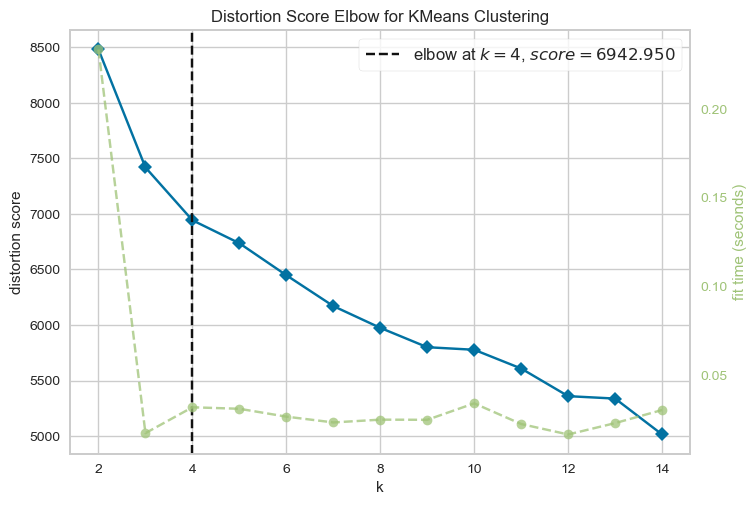

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [90]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,15))
visualizer.fit(df_prep_scaled)
visualizer.show()

In [91]:
sse = {}

for k in range(2, 15):

    print(f"Fitting pipe with {k} clusters")

    clustering_model = KMeans(n_clusters = k)
    clustering_model.fit(df_prep_scaled)

    sse[k] = clustering_model.inertia_

Fitting pipe with 2 clusters
Fitting pipe with 3 clusters
Fitting pipe with 4 clusters
Fitting pipe with 5 clusters
Fitting pipe with 6 clusters
Fitting pipe with 7 clusters
Fitting pipe with 8 clusters
Fitting pipe with 9 clusters
Fitting pipe with 10 clusters
Fitting pipe with 11 clusters
Fitting pipe with 12 clusters
Fitting pipe with 13 clusters
Fitting pipe with 14 clusters


## Elbow curve (CORE IDEA)

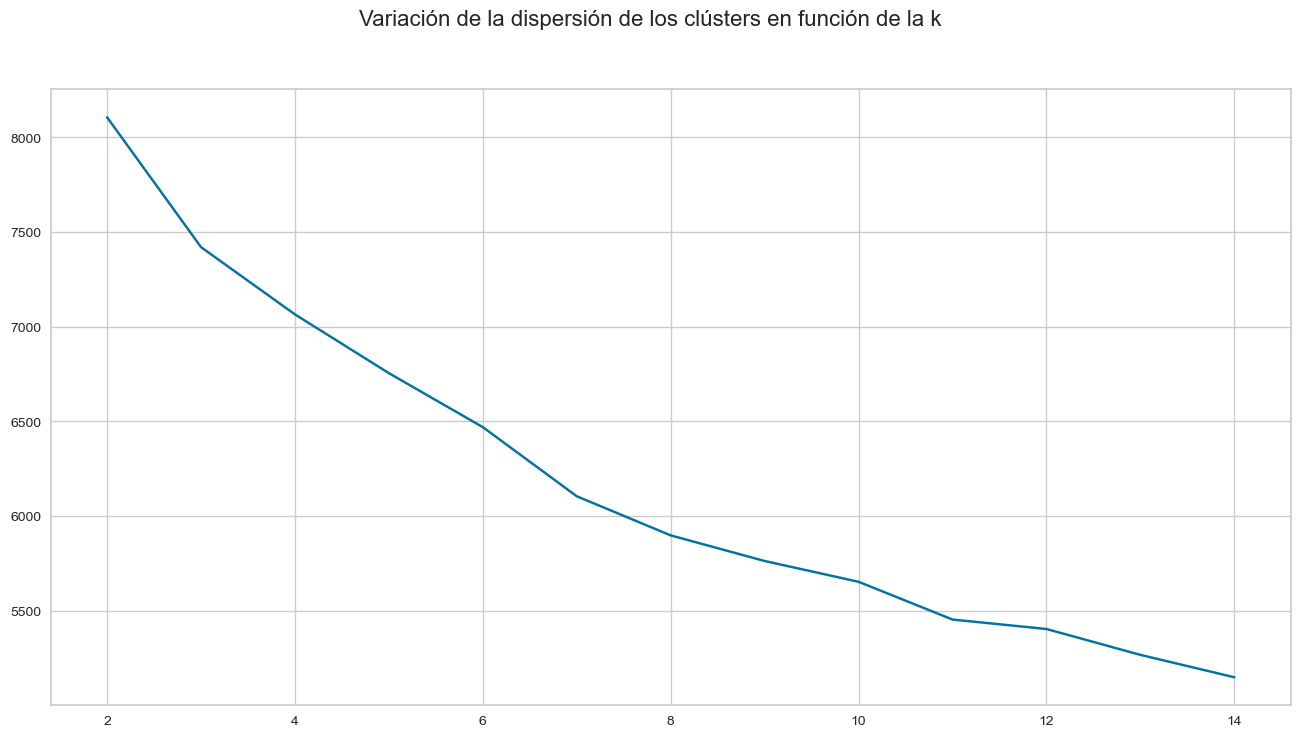

In [92]:
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot()

x_values = list(sse.keys())
y_values = list(sse.values())

ax.plot(x_values, y_values, label = "Inertia/dispersión de los clústers")
fig.suptitle("Variación de la dispersión de los clústers en función de la k", fontsize = 16);

Segmentación con k = X

## Segmentación de los items con K = 6

In [93]:
pipe2 = Pipeline(steps = [
    ("Imputer", KNNImputer()),
    ("RobustScaler", RobustScaler(quantile_range = (0, 99.0))),
    ("Clustering", KMeans(n_clusters = 7, random_state = 42))
])

In [94]:
pipe2.fit(df_prep_scaled)

Pipeline(steps=[('Imputer', KNNImputer()),
                ('RobustScaler', RobustScaler(quantile_range=(0, 99.0))),
                ('Clustering', KMeans(n_clusters=7, random_state=42))])

In [95]:
labels = pipe2.predict(df_prep_scaled)

In [96]:
df_final = df_prep.copy()

In [97]:
df_final["cluster"] = labels

In [98]:
df_final["cluster"] = df_final["cluster"] + 1

# Descripcion de los Clusters

In [99]:
bool_columns = df_final.select_dtypes('bool').columns

In [100]:
for col in bool_columns:
  df_final[col] = np.where(df_final[col]==True,1,0)

pip install Jinja2


In [103]:

df_final.groupby('cluster').describe().T.style.background_gradient(cmap = 'Blues', axis = 1)

In [104]:
df_final.groupby('cluster')

In [105]:
df_final

,average_weekly_revenue,flag_high_price,flag_high_sells,flag_high_revenue,average_price,max_price_change,price_changes_total,total_units_sold,average_weekly_units_sold,max_days_from_last_sale,days_from_last_sale_mean,sells_every_week,sells_every_month,flag_middle_week_item,flag_end_week_item,flag_middle_month_item,flag_end_month_item,flag_middle_quarter_item,flag_end_quarter_item,flag_middle_year_item,flag_end_year_item,event_boosted,event_decreased,cluster
item,,,,,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001,164.652447,1,0,0,11.468528,0.041027,1912,4093,14.937956,3.0,1.044423,0,0,0,1,1,0,0,0,0,1,0,1,5
ACCESORIES_1_002,97.451250,0,0,0,5.276737,0.052213,1912,5059,18.463504,92.0,3.333511,0,0,1,0,0,1,0,1,0,1,0,1,6
ACCESORIES_1_003,20.669714,0,0,0,3.947623,0.101010,1912,1435,5.237226,22.0,1.951673,0,0,1,0,1,0,0,1,0,0,1,0,6
ACCESORIES_1_004,857.293759,0,1,1,5.978931,0.065029,1912,39175,142.974453,5.0,1.010460,1,1,0,1,0,0,0,1,0,0,0,1,4
ACCESORIES_1_005,203.100645,0,1,0,3.837978,0.080645,1912,14621,53.361314,8.0,1.055647,0,0,1,0,1,0,0,0,0,1,0,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SUPERMARKET_3_823,186.490248,0,0,0,3.345946,0.119751,1912,15388,56.160584,277.0,29.548640,0,0,0,1,0,0,1,0,0,1,0,1,2
SUPERMARKET_3_824,92.138715,0,0,0,3.026944,0.041322,1912,8325,30.383212,57.0,3.974372,0,0,0,1,0,0,0,1,1,0,0,1,2
SUPERMARKET_3_825,240.102622,1,0,0,4.934212,0.075285,1912,13526,49.364964,68.0,4.798117,0,0,0,1,1,0,1,0,0,0,0,1,5


In [106]:
df_wcluster = df_original.copy()

In [107]:
df_wcluster['cluster'] = df_wcluster['item'].map(df_final['cluster'])

In [108]:
df_wcluster

,item,category,department,store,city,Qsale,date,yearweek,event,weekday,unit_price,total_venta,cluster
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,New York,0,2011-01-29,201105,No_event,6,12.7414,0.000,5
1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Greenwich_Village,New York,0,2011-01-29,201105,No_event,6,5.2801,0.000,6
2,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,Greenwich_Village,New York,0,2011-01-29,201105,No_event,6,3.9501,0.000,6
3,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Greenwich_Village,New York,0,2011-01-29,201105,No_event,6,5.7722,0.000,4
4,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,Greenwich_Village,New York,0,2011-01-29,201105,No_event,6,3.9634,0.000,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58327365,SUPERMARKET_3_823,SUPERMARKET,SUPERMARKET_3,Queen_Village,Philadelphia,1,2016-04-24,201617,No_event,7,3.5760,3.576,2
58327366,SUPERMARKET_3_824,SUPERMARKET,SUPERMARKET_3,Queen_Village,Philadelphia,0,2016-04-24,201617,No_event,7,2.9760,0.000,2
58327367,SUPERMARKET_3_825,SUPERMARKET,SUPERMARKET_3,Queen_Village,Philadelphia,0,2016-04-24,201617,No_event,7,4.7760,0.000,5
58327368,SUPERMARKET_3_826,SUPERMARKET,SUPERMARKET_3,Queen_Village,Philadelphia,3,2016-04-24,201617,No_event,7,1.5360,4.608,2


In [109]:
# Asegurar que 'date' es datetime
df_wcluster['date'] = pd.to_datetime(df_wcluster['date'])

In [110]:
df_wcluster.to_pickle('df_wcluster_all_k7.pkl')

In [111]:
productos_por_cluster = df_wcluster.groupby('cluster')['item'].nunique()

In [112]:
productos_por_cluster

cluster
1    309
2    632
3    317
4    339
5    435
6    704
7    313
Name: item, dtype: int64

In [113]:
unidades_vendidas = df_wcluster.groupby('cluster')['Qsale'].sum()

In [114]:
unidades_vendidas

cluster
1     3676958
2     7653896
3    12083848
4    21529143
5     3447197
6    10344211
7     6960156
Name: Qsale, dtype: int64

In [115]:
precio_promedio = df_wcluster.groupby('cluster')['unit_price'].mean()

In [116]:
precio_promedio

cluster
1    10.070908
2     3.159207
3     4.856650
4     4.769993
5     7.528387
6     5.672168
7     4.560644
Name: unit_price, dtype: float64